In [50]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [51]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS=40

In [52]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "R:/coding/Disease_Prediction/Tomato_img",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 6000 files belonging to 6 classes.


In [53]:
class_names = dataset.class_names
class_names

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [54]:
len(dataset)

188

In [55]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 2 4 1 1 0 5 5 1 5 5 0 3 4 5 5 2 1 3 4 1 2 2 3 1 1 3 0 2 4 4]


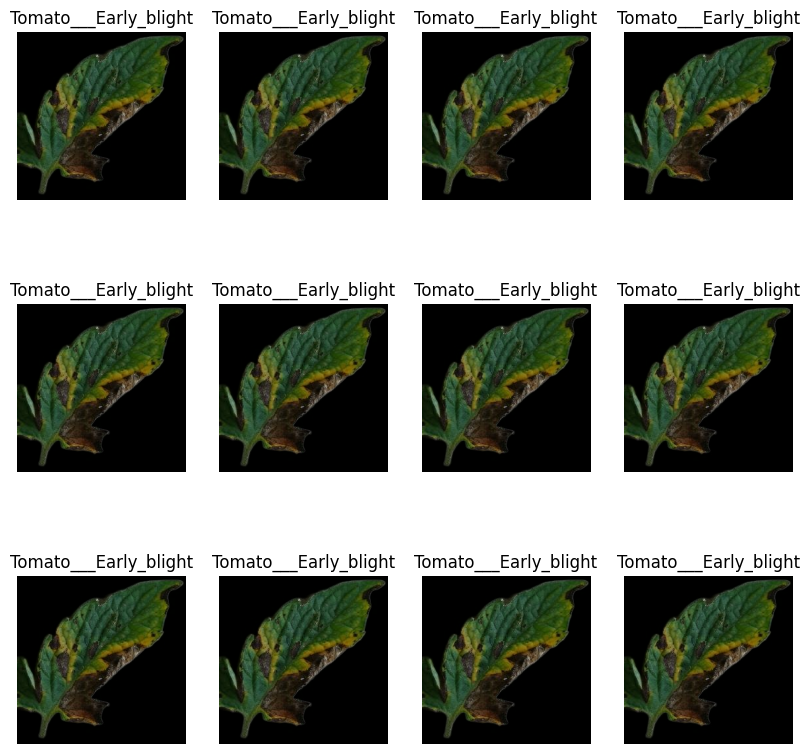

In [56]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)   
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    plt.axis("off")

In [57]:
train_size = 0.8
len(dataset)*train_size

150.4

In [58]:
train_ds = dataset.take(150)
len(train_ds)

150

In [59]:
print(train_ds)


<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [60]:
test_ds = dataset.skip(150)
len(test_ds)

38

In [61]:
val_size = 0.1
len(dataset)*val_size

18.8

In [62]:
val_ds = test_ds.take(18)
len(val_ds)

18

In [63]:
test_ds = test_ds.skip(18)
len(test_ds)

20

In [64]:
def get_dataset_partition_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:          
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)

    return train_ds, val_ds, test_ds

In [65]:
train_ds, val_ds, test_ds = get_dataset_partition_tf(dataset)

In [66]:
len(train_ds)

150

In [67]:
len(test_ds)

20

In [68]:
len(val_ds)

18

In [69]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds= test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [70]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1.0 / 255)
])

In [71]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2)
])


In [72]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 6

model = tf.keras.Sequential([
    tf.keras.Input(shape=input_shape),
    data_augmentation,
    resize_and_rescale,

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(n_classes, activation='softmax')
])


In [73]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,839,750 (56.61 MB)

 Trainable params: 14,839,750 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

In [74]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [75]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=30,
)

Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 132s 852ms/step - accuracy: 0.2953 - loss: 1.7171 - val_accuracy: 0.5821 - val_loss: 1.1576
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 127s 845ms/step - accuracy: 0.6709 - loss: 0.9054 - val_accuracy: 0.6429 - val_loss: 1.1313
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 123s 822ms/step - accuracy: 0.7350 - loss: 0.7170 - val_accuracy: 0.7411 - val_loss: 0.7558
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 123s 822ms/step - accuracy: 0.7834 - loss: 0.6062 - val_accuracy: 0.7304 - val_loss: 0.8130
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 125s 833ms/step - accuracy: 0.8269 - loss: 0.4877 - val_accuracy: 0.7321 - val_loss: 0.9176
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 123s 822ms/step - accuracy: 0.8465 - loss: 0.4441 - val_accuracy: 0.7786 - val_loss: 0.7629
Epoch 7/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 123s 821ms/step - accuracy: 0.8715 - loss: 0.3648 - val_accuracy: 0.8304 - val_loss: 0.4497
Epoch 8/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 124s 825ms/step - accuracy: 0.8577 -

In [76]:
scores = model.evaluate(test_ds)

20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 226ms/step - accuracy: 0.9092 - loss: 0.2974


In [77]:
scores

[0.3310479521751404, 0.8968750238418579]

In [78]:
history

In [79]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 150}

In [80]:
history.history['accuracy']

[0.42934781312942505,
 0.6835284233093262,
 0.7539715766906738,
 0.7943143844604492,
 0.8170986771583557,
 0.8497073650360107,
 0.8618311285972595,
 0.8639214038848877,
 0.8724916577339172,
 0.8735367655754089,
 0.8806437849998474,
 0.8902592062950134,
 0.9025919437408447,
 0.9013378024101257,
 0.9132525324821472,
 0.8982023596763611,
 0.9182692170143127,
 0.9088628888130188,
 0.9239130616188049,
 0.9239130616188049,
 0.9354097247123718,
 0.931438148021698,
 0.9335284233093262,
 0.9479514956474304,
 0.9335284233093262,
 0.9251672029495239,
 0.9387542009353638,
 0.9433528184890747,
 0.9366638660430908,
 0.9452341198921204]

In [81]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

first image to predict
actual label: Tomato___Bacterial_spot
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
predicted label: Tomato___Bacterial_spot


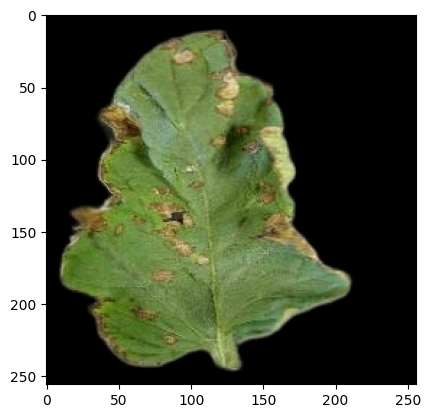

In [82]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [83]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


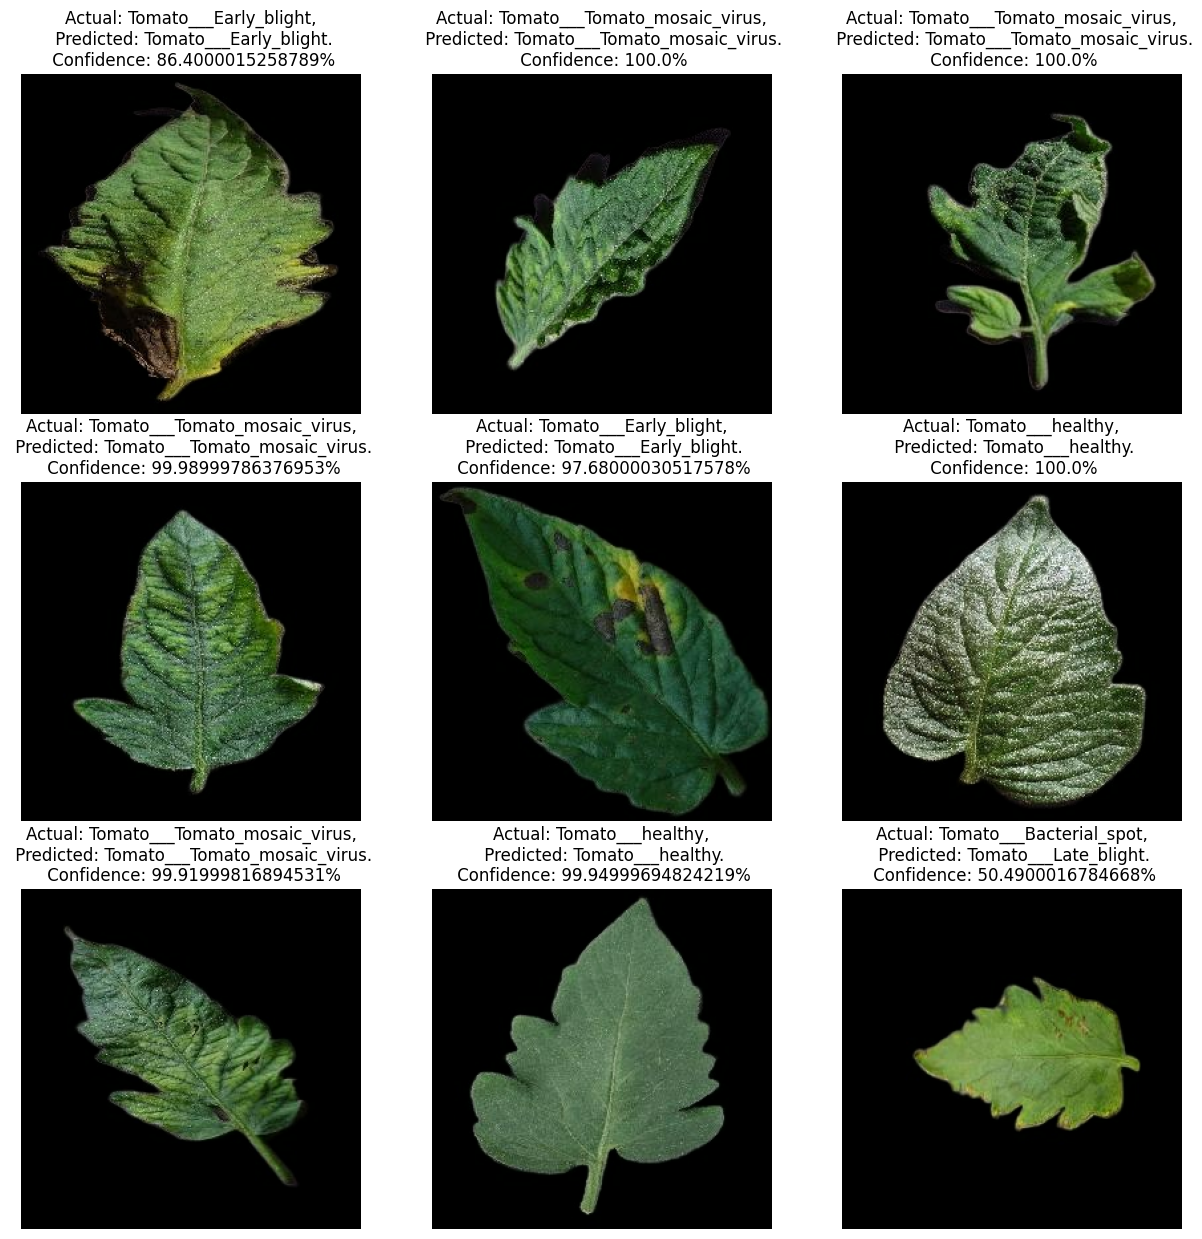

In [84]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [87]:


# Target model version path
model_dir = "../models/tomato_model"


# Get numeric folder names only


# Safely get the next version
model_version = 3

# Save the model
model.save(f"{model_dir}/{model_version}.h5")